Dataset Shape: (2199, 12)

First 5 rows of the cleaned data:
  Patient_ID  Age  Gender Specimen_Type   Amoxicillin Ciprofloxacin  \
0      P0001   36  Female         Blood  Intermediate     Sensitive   
1      P0002   59  Female         Blood  Intermediate     Resistant   
2      P0003   13  Female         Urine  Intermediate     Sensitive   
3      P0004    4  Female        Sputum  Intermediate     Resistant   
4      P0005   51    Male         Urine     Resistant     Sensitive   

      Meropenem    Vancomycin      Colistin       Test_Method  \
0  Intermediate  Intermediate  Intermediate  Automated System   
1  Intermediate     Sensitive  Intermediate               MIC   
2     Resistant  Intermediate     Resistant               MIC   
3     Sensitive  Intermediate  Intermediate  Automated System   
4     Resistant  Intermediate  Intermediate  Automated System   

  Resistance_Genes    Outcome  
0              KPC        ICU  
1              KPC  Recovered  
2           OXA-48       

/tmp/ipython-input-3263244964.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Outcome', palette='viridis')


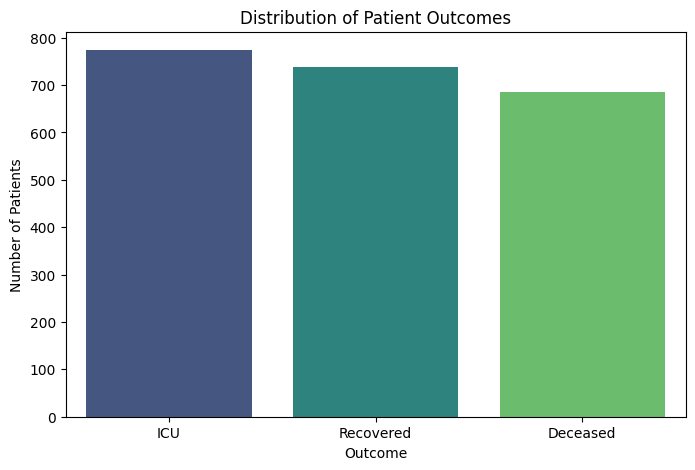

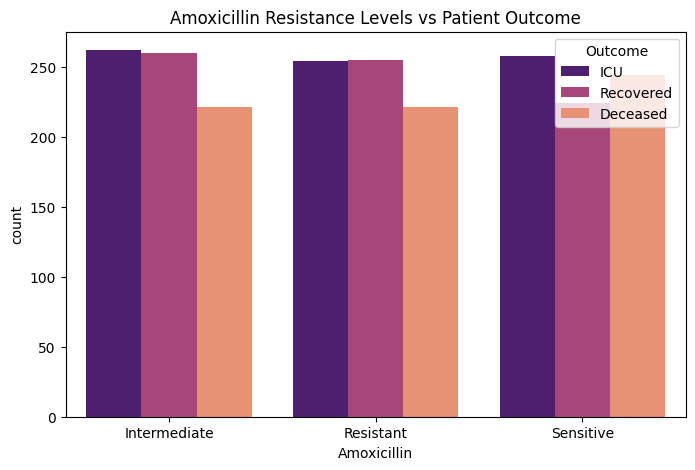

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Loading the data
df = pd.read_csv('antibiotic_resistance_tracking (Project Data).csv')

# 2. Data Cleaning
# Filling missing values in 'Resistance_Genes' with 'None Detected'
df['Resistance_Genes'] = df['Resistance_Genes'].fillna('None Detected')

# Drop any rows where Patient_ID might be missing (cleanup)
df = df.dropna(subset=['Patient_ID'])

# 3. Quick Overview
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows of the cleaned data:")
print(df.head())

# 4. Basic Descriptive Statistics
print("\nSummary of Age:")
print(df['Age'].describe())

# 5. Visualizing the Outcomes (Your Target Variable)
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Outcome', palette='viridis')
plt.title('Distribution of Patient Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Number of Patients')
plt.show()

# 6. Visualizing Resistance for a specific antibiotic (e.g., Amoxicillin)
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Amoxicillin', hue='Outcome', palette='magma')
plt.title('Amoxicillin Resistance Levels vs Patient Outcome')
plt.show()

In [2]:
from scipy.stats import chi2_contingency

# 1. Creating a Cross-tabulation (contingency table)
contingency_table = pd.crosstab(df['Outcome'], df['Resistance_Genes'])
print("Contingency Table (Counts):")
print(contingency_table)

# 2. Runing the Chi-Square Test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\n--- Chi-Square Test Results ---")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p_value:.4f}")

# 3. Interpreting the result
alpha = 0.05
if p_value < alpha:
    print("Conclusion: There is a SIGNIFICANT relationship between Resistance Genes and Outcome.")
else:
    print("Conclusion: There is NO significant relationship between Resistance Genes and Outcome.")

Contingency Table (Counts):
Resistance_Genes  KPC  NDM-1  None Detected  OXA-48  VIM
Outcome                                                 
Deceased          142    128            136     139  141
ICU               145    156            155     159  159
Recovered         138    140            146     152  163

--- Chi-Square Test Results ---
Chi-Square Statistic: 2.0260
P-Value: 0.9802
Conclusion: There is NO significant relationship between Resistance Genes and Outcome.


Model Accuracy: 32.27%

Detailed Report:
              precision    recall  f1-score   support

    Deceased       0.26      0.25      0.26       134
         ICU       0.33      0.37      0.35       153
   Recovered       0.38      0.34      0.36       153

    accuracy                           0.32       440
   macro avg       0.32      0.32      0.32       440
weighted avg       0.32      0.32      0.32       440



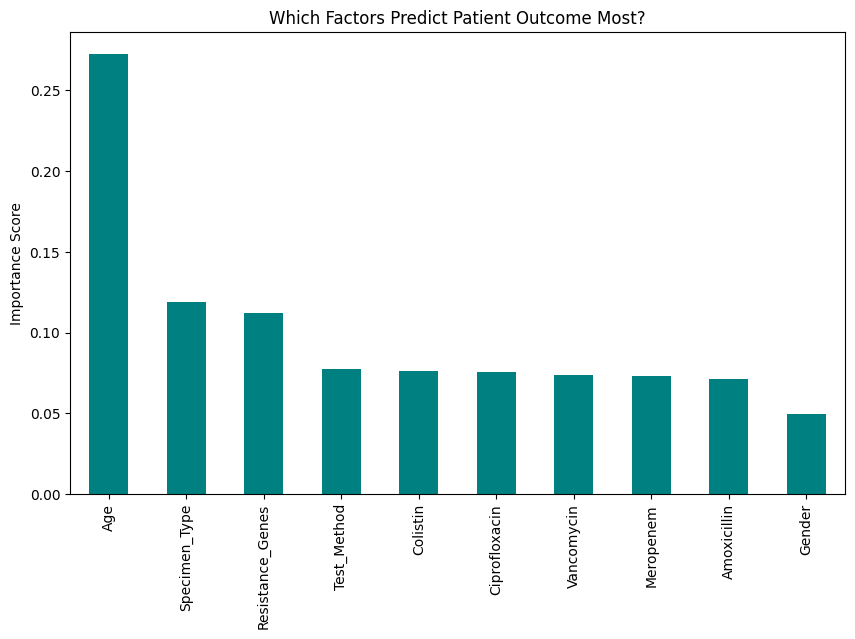

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Prepare the data: Convert text categories into numbers
le = LabelEncoder()
df_ml = df.copy()

# List of columns to encode
cols_to_encode = ['Gender', 'Specimen_Type', 'Amoxicillin', 'Ciprofloxacin',
                  'Meropenem', 'Vancomycin', 'Colistin', 'Test_Method', 'Resistance_Genes']

for col in cols_to_encode:
    df_ml[col] = le.fit_transform(df_ml[col].astype(str))

# 2. Define Features (X) and Target (y)
X = df_ml[['Age'] + cols_to_encode]
y = df['Outcome'] # This is what I want to predict

# 3. Spliting the data into Training (80%) and Testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize and Train the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Make Predictions and check Accuracy
predictions = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, predictions):.2%}")
print("\nDetailed Report:")
print(classification_report(y_test, predictions))

# 6. Feature Importance: Which factor matters most?
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
importances.plot(kind='bar', color='teal')
plt.title('Which Factors Predict Patient Outcome Most?')
plt.ylabel('Importance Score')
plt.show()

--- Model Performance Comparison ---
Logistic Regression Accuracy: 31.14%
Random Forest Accuracy: 32.27%
Gradient Boosting Accuracy: 34.77%


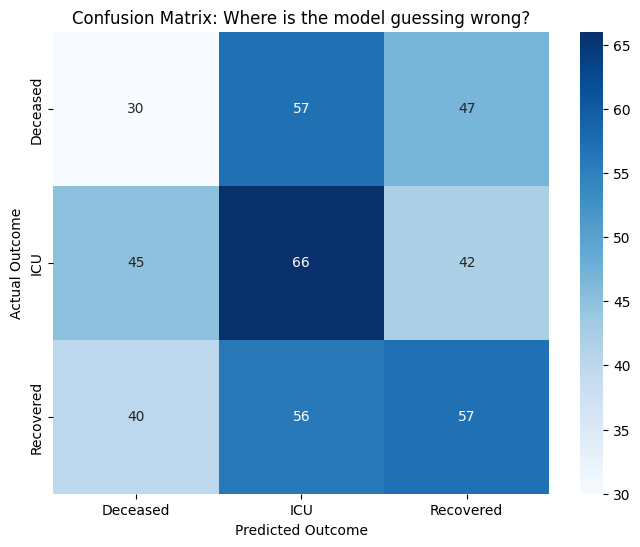


--- ANOVA Test (Age vs Outcome) ---
P-value: 0.7642
Result: There is no significant difference in age between the outcome groups.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# 1. Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# 2. Train and evaluate each model
print("--- Model Performance Comparison ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2%}")

# 3. Create a Confusion Matrix for the best performing model
# (This shows exactly where the model is making mistakes)
best_model = models["Gradient Boosting"] # Usually Gradient Boosting performs well
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix: Where is the model guessing wrong?')
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()

# 4. Statistical Test: ANOVA (Analysis of Variance)
# Checking if the average age is actually different between the three outcome groups
import scipy.stats as stats
f_stat, p_val = stats.f_oneway(df[df['Outcome']=='ICU']['Age'],
                               df[df['Outcome']=='Recovered']['Age'],
                               df[df['Outcome']=='Deceased']['Age'])

print(f"\n--- ANOVA Test (Age vs Outcome) ---")
print(f"P-value: {p_val:.4f}")
if p_val < 0.05:
    print("Result: Age significantly affects the patient outcome.")
else:
    print("Result: There is no significant difference in age between the outcome groups.")